<h1>Analyze Failure Cost

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('aps_failure_training_set.csv', skiprows=20)
test_df = pd.read_csv('aps_failure_test_set.csv', skiprows=20)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
train_df.head()

Training data shape: (60000, 171)
Test data shape: (16000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


<h2>Data Cleaning

In [3]:
train_df.replace('na', np.nan, inplace=True)
test_df.replace('na', np.nan, inplace=True)

numeric_cols = train_df.columns[1:]
train_df[numeric_cols] = train_df[numeric_cols].astype(float)
test_df[numeric_cols] = test_df[numeric_cols].astype(float)

train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(train_df.median(numeric_only=True), inplace=True)

train_df['class'] = train_df['class'].map({'neg': 0, 'pos': 1})
test_df['class'] = test_df['class'].map({'neg': 0, 'pos': 1})


print("Data cleaning and type conversion complete.")
print(f"Training labels distribution:\n{train_df['class'].value_counts()}")
print(f"Test labels distribution:\n{test_df['class'].value_counts()}")


Data cleaning and type conversion complete.
Training labels distribution:
class
0    59000
1     1000
Name: count, dtype: int64
Test labels distribution:
class
0    15625
1      375
Name: count, dtype: int64


<h2>Define labels

In [4]:
X_train = train_df.drop('class', axis=1)
y_train = train_df['class']
X_test = test_df.drop('class', axis=1)
y_test = test_df['class']

print(f"Features and labels defined. Training samples: {X_train.shape[0]}, Features: {X_train.shape[1]}")

Features and labels defined. Training samples: 60000, Features: 170


<h2>Model Training

In [5]:
import time

print("starting model training... (this may take a while)")
start_time = time.time()

model = LogisticRegression(class_weight={0: 1, 1: 50}, max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Logistic Regression model trained successfully in {elapsed_time:.2f} seconds.")

starting model training... (this may take a while)
Logistic Regression model trained successfully in 279.11 seconds.


<h2>Evaluation

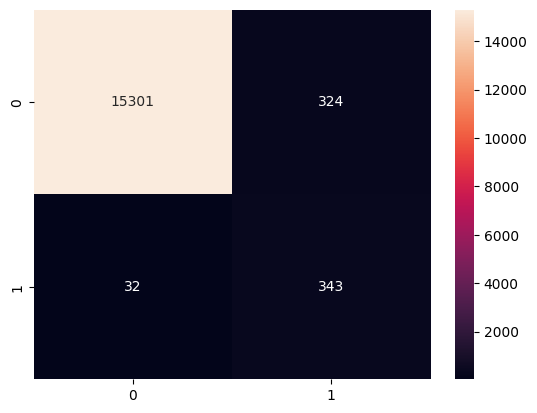

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.51      0.91      0.66       375

    accuracy                           0.98     16000
   macro avg       0.76      0.95      0.82     16000
weighted avg       0.99      0.98      0.98     16000

Type 1 Cost: 3240
Type 2 Cost: 16000
Total Cost: 19240


In [6]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print(classification_report(y_test, y_pred))

cost_1 = 10
cost_2 = 500
type_1_errors = cm[0, 1]
type_2_errors = cm[1, 0]
total_cost = cost_1 * type_1_errors + cost_2 * type_2_errors

print(f'Type 1 Cost: {type_1_errors * cost_1}')
print(f'Type 2 Cost: {type_2_errors * cost_2}')
print(f'Total Cost: {total_cost}')

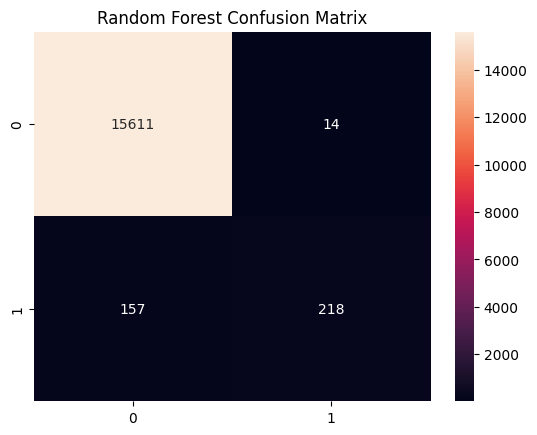

Random Forest model evaluation complete. Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.94      0.58      0.72       375

    accuracy                           0.99     16000
   macro avg       0.96      0.79      0.86     16000
weighted avg       0.99      0.99      0.99     16000

Random Forest Type 1 Cost: 140
Random Forest Type 2 Cost: 78500
Random Forest Total Cost: 78640


In [7]:
rf_model = RandomForestClassifier(class_weight={0: 1, 1: 50}, n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

print("Random Forest model evaluation complete. Classification report:")
print(classification_report(y_test, y_pred_rf))

type_1_errors_rf = cm_rf[0, 1]
type_2_errors_rf = cm_rf[1, 0]
total_cost_rf = cost_1 * type_1_errors_rf + cost_2 * type_2_errors_rf

print(f"Random Forest Type 1 Cost: {type_1_errors_rf * cost_1}")
print(f"Random Forest Type 2 Cost: {type_2_errors_rf * cost_2}")
print(f"✅ Random Forest Total Cost: {total_cost_rf}")

<h2>Model Performance

**Logistic Regression**

High accuracy (98%), but much lower precision and recall for the minority class (positive / failure).

Recall for failure detection: 91%, meaning it catches most failures.

Precision for failure detection: 51%, meaning nearly half of its failure predictions are false alarms.

**Random Forest**

Higher precision (94%), but much lower recall (58%) for the positive class.

It is more conservative and misses more failures, but fewer false alarms.

<h2>Cost Analysis

**Logistic Regression Total Cost: 19,240**

Type 1 (False Positives): 3,240

Type 2 (False Negatives): 16,000

**Random Forest Total Cost: 78,640**

Type 1 (False Positives): 140

Type 2 (False Negatives): 78,500